---
# **データサイエンス基礎　第6回課題**
## **【データ前処理】売上グラフの作成**
---
### 1. データの概要
　今回扱うデータは，[7月における文房具の売り上げに関するデータ](https://github.com/hatakeke/DataScience-Basic/blob/main/%E7%AC%AC6%E5%9B%9E/ds06_sample_data.xlsx)である．各行には，日付，曜日，商品名，単価，数量の5列のデータが格納されている．ただし，データの中には全角スペースが含まれたり，表記ゆれがあったり，外れ値があったりして，データを分析する妨げになる可能性がある．  
### 2. データの前処理（外れ値の処理と名寄せの実施）
　前処理はデータのファイル形式であるExcelのフィルタ機能を用いる方法や，開発環境であるVisual Studio Codeの置換機能を用いる方法も考えられるが，今回はどの環境でも等しく動作し，個人の操作によらない方法として，Pythonライブラリを活用する方法を用いる．まず，存在する欠損値として以下の3種類挙げられる．  
- ”***” という文字列  
- ”N/A” という文字列  
- ”9999” や ”-1” といった売上個数の外れ値  
  
これらを全て ”NaN” という文字列に置換することを行う．
　また，商品名の表記ゆれに関しては，文字列の先頭に全角スペースが入っていたり，同じ商品でも漢字・平仮名・片仮名，大文字・小文字の表記ゆれが見られる．これに関しては，以下のような手順に従って名寄せを行った．  
- (1) 日本語を含む文字列の全角・半角変換を行うためのライブラリ：jaconv の z2h メソッドを用いて，全角のアルファベットを全て小文字に変換  
- (2) 全角スペースを消去
- (3) upper メソッドを用いて，全ての小文字を大文字に変換  
- (4) ”BLACK” という文字列を ”黒” に置換
- (5) ”RED” という文字列を ”赤” に置換
- (6) ”ハサミ” を ”はさみ” に統一
- (7) ”シャープペン” を ”シャーペン” に統一
- (8) ”エンピツ” を ”鉛筆” に統一

In [99]:
# ライブラリの読み込み
# %pip install --upgrade pip
# %pip install numpy
# %pip install matplotlib
# %pip install pandas
# %pip install openpyxl
# %pip install sympy
# %pip install scipy
# %pip install re
# %pip install jaconv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import sympy as sp
import scipy.stats as stats
import re
import jaconv 

# 名寄せを行う関数の定義
def Naming(column):
    column = jaconv.z2h(column, kana=False, digit=True, ascii=True)
    column = re.sub(r'\s+', '', column)
    column = column.upper()
    column = re.sub(r'BLACK', '黒', column)
    column = re.sub(r'RED', '赤', column)
    column = re.sub(r'ハサミ', 'はさみ', column)
    column = re.sub(r'シャープペン', 'シャーペン', column)
    column = re.sub(r'エンピツ', '鉛筆', column)
    return column

# 売上データのExcelファイルの読み込み
df = pd.read_excel('ds06_sample_data.xlsx')

# データの前処理
drop_index = []
for index, row in df.iterrows():
    if row['日付'] == '***':
        drop_index.append(index)
    elif row['数量'] == 'N/A' or not (0 < row['数量'] < 10):
        drop_index.append(index)
    else:
        # 商品名を名寄せ
        row['商品名'] = Naming(row['商品名'])

# 欠損値のある行を削除
df.drop(index=drop_index, inplace=True)

# CSV形式で保存
df.to_csv('ds06_sample_data.csv')
display(df)

,日付,曜日,商品名,単価,数量
0,7月1日,水,ボールペン黒,100,1
1,7月1日,水,鉛筆,80,5
2,7月1日,水,ボールペン赤,100,1
3,7月1日,水,ボールペン赤,100,2
4,7月1日,水,ノート,150,2
...,...,...,...,...,...
1025,7月31日,金,ノート,150,1
1026,7月31日,金,鉛筆,80,1
1027,7月31日,金,シャーペン,300,2
1028,7月31日,金,ノート,150,1


　データフレームの出力やCVS形式で保存されたファイルより，欠損値の処理と名寄せが正しく行われたことが確認できる．
### 3. 日毎の売上高
　日毎の売上高をグラフに描画する．グラフの形式は折れ線グラフが適切であると考えられる．また，日毎のグラフを作成するために，日付のフォーマットを整数にした方が扱いやすいと考えられる．さらに，売上高は単価と数量の積で計算可能であるため，データフレームに追加する．加えて，その日の売上高は，全ての商品の売上の合計値を計算する必要がある．  
　以上を踏まえて，以下のようにグラフを描画する．

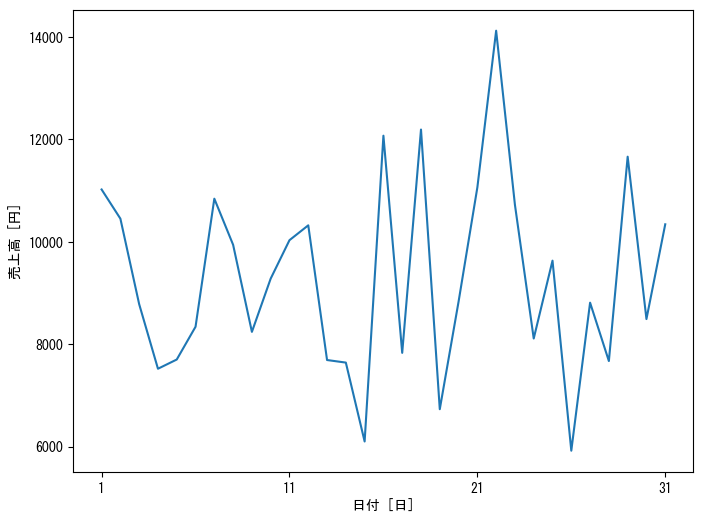

In [100]:
for index, row in df.iterrows():
    date = re.match(r'7月(\d+)日', row['日付'])
    if date is not None:
        # グラフ描画のために日付をフォーマット
        row['日付'] = int(date.group(1))

# 売上 = 単価 × 数量 を計算して列に追加
df['売上'] = df['単価'] * df['数量']

# 日付毎に売上高を計算
df_daily = df.groupby('日付').sum()

# 日付毎の売上高を折れ線グラフに描画
plt.rcParams['font.family'] = 'MS Gothic'
fig = plt.figure(figsize=(8, 6))
plt.plot(df_daily.sort_values(by=['日付'])['売上'])
plt.xlabel('日付 [日]')
plt.xticks([1, 11, 21, 31], ['1', '11', '21', '31'])
plt.ylabel('売上高 [円]')
plt.show()

　日毎の結果を見ると，変動が激しく，売上高との相関が分かりにくい．したがって，曜日毎の売上高を確認する．  
### 4. 曜日毎の売上高
　曜日毎の売上高をグラフに描画する．日付とは異なり，連続な時間変化を示すグラフではないため，グラフの形式は棒グラフが適切であると考えられる．また，曜日毎の売上高を合計して新しいデータフレームに保存しておく必要がある．  
　以上を踏まえて，以下のようにグラフを描画する．

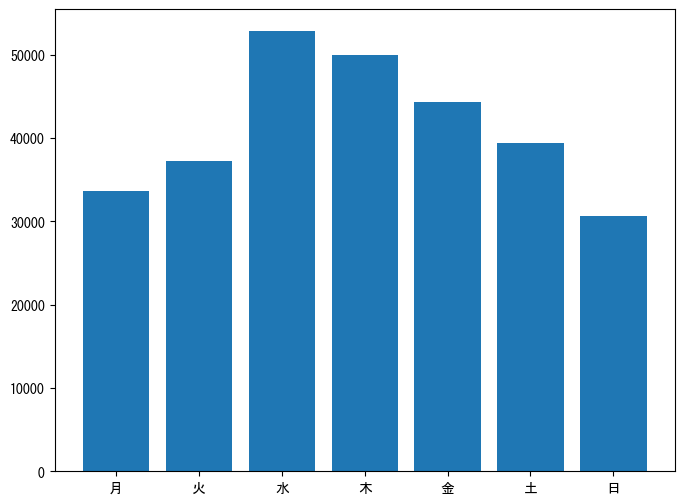

In [101]:
# 曜日順にソートし，曜日毎の売上高を計算
day = ['月', '火', '水', '木', '金', '土', '日']
df['曜日'] = pd.Categorical(df['曜日'], categories=day, ordered=True)
df_weekly = df.sort_values('曜日')
df_weekly = df_weekly.groupby('曜日', observed=False).sum()

# 曜日毎の売上高を折れ線グラフに描画
fig = plt.figure(figsize=(8, 6))
plt.bar(df_weekly.index, df_weekly['売上'])
plt.show()

　曜日毎の結果を見ると，水曜日が最も売上が高く，週の終始にかけて売上が減少する傾向があると読み取れる．これらを踏まえて売上の戦略を考えると効果的であると考えられる．最後に，商品ごとの売上高も確認する．  
### 5. 商品毎の売上高
　商品毎の売上高をグラフに描画する．こちらも，連続な時間変化を示すグラフではないため，グラフの形式は棒グラフが適切であると考えられる．また，同様に，商品毎の売上高を合計して新しいデータフレームに保存しておく必要がある．  
　以上を踏まえて，以下のようにグラフを描画する．

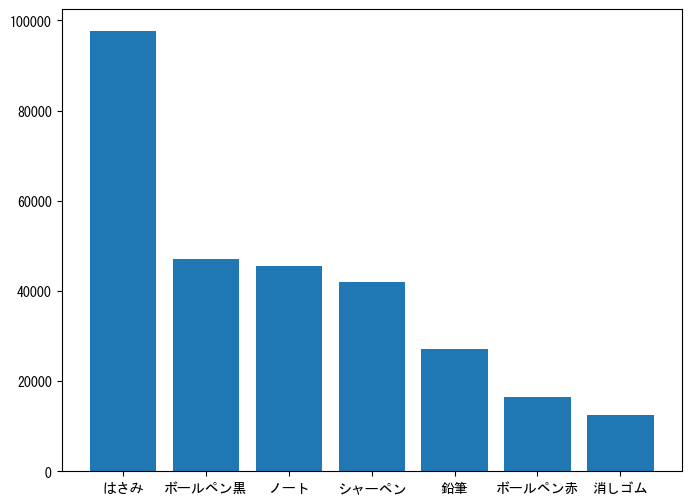

In [102]:
# 商品毎の売上高を計算し，売上高順にソート
df_product = pd.DataFrame(df.groupby('商品名')['売上'].sum())
df_product = df_product.sort_values('売上', ascending=False)

# 曜日毎の売上高を折れ線グラフに描画
fig = plt.figure(figsize=(8, 6))
plt.bar(df_product.index, df_product['売上'])
plt.show()

　したがって，はさみが最も多く売れ，消しゴムが最も売れない商品であることが分かった．はさみの売上高は，売上高第2位のボールペン黒の2倍程度あり，かなり差があることが確認できる．

### 感想  
　データの前処理に関して，以前はExcelを活用してきたが，今回はPythonを利用した．Excelでは，データが視覚的に確認しやすいほか，機能が分かり易いというメリットがあったが，今回のようにデータに不備があったり，目的のグラフを作成するための整頓がされていなかったりするデータに対しては，データ処理が手作業になり，効率的ではなくなるという問題があった．その点がPythonでは，汎用的にデータ処理が行えるほか，同じようなデータ処理やグラフ作成の仕事があった場合に，同じ作業をしなくて済むというメリットが有ると分かった．ただし，Excelのように視覚的にデータを扱わないことによるミスが発生することが考えられるため，逐一データを出力したり，保存したりして，ミスをしない工夫をすることが要求される．
　